In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re


In [29]:
# -------- 1. Load data --------
def load_data(path):
    df = pd.read_excel(path)
    queries = df['Queries'].dropna().str.strip().str.lower()
    return queries


queries = load_data("SkyRocket Data.xlsx")



In [24]:
# -------- 2. Basic Profile --------
def profile_dataset(queries):
    total = len(queries)
    nulls = queries.isnull().sum()
    duplicates = queries.duplicated().sum()
    unique = queries.nunique()

    print(f"Total queries: {total}")
    print(f"Null entries: {nulls}")
    print(f"Exact duplicates: {duplicates}")
    print(f"Unique queries: {unique}")

    if duplicates > 0:
        print("\n🔁 Exact Duplicates Found:")
        dup_rows = queries[queries.duplicated(keep=False)]  # all duplicate rows, not just second instances
        dup_df = pd.DataFrame({
            'Row Index': dup_rows.index + 2,
            'Query': dup_rows.values
        }).sort_values(by='Query')
        print(dup_df.to_string(index=False))




profile_dataset(queries)


Total queries: 6539
Null entries: 0
Exact duplicates: 5
Unique queries: 6534

🔁 Exact Duplicates Found:
 Row Index                                                   Query
      2851        i do not know how to speak with customer service
      2852        i do not know how to speak with customer service
      3340 i don't know what to do to check the withdrawal penalty
      3346 i don't know what to do to check the withdrawal penalty
      3452               i have a problem with forgotten passwords
      3453               i have a problem with forgotten passwords
      4549           i want assistance contacting customer service
      4550           i want assistance contacting customer service
      4867             i want help to edit my personal information
      4868             i want help to edit my personal information


Min length: 6
Max length: 60
Average length: 42.55


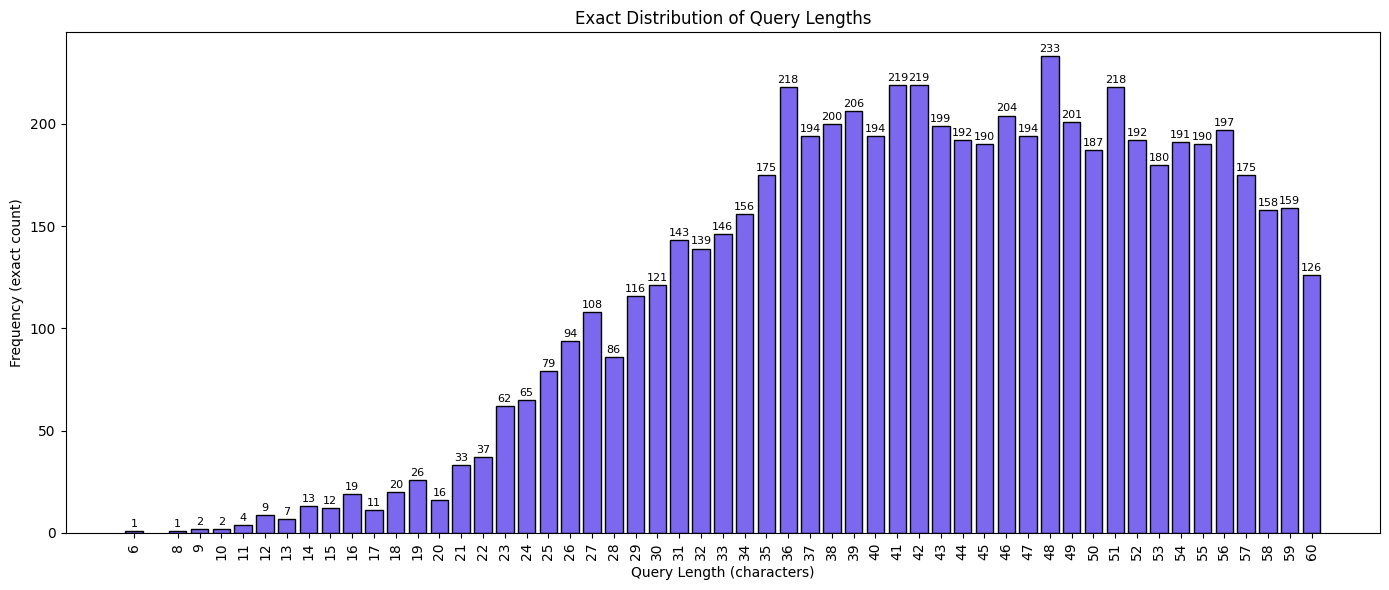

In [32]:
# -------- 3. Query Length Stats --------



def analyze_query_lengths(queries):
    # Lengths of each query
    lengths = queries.str.len()

    # Compute frequency of each length
    length_counts = Counter(lengths)
    lengths_sorted = sorted(length_counts.items())  # List of (length, count) tuples

    x = [item[0] for item in lengths_sorted]
    y = [item[1] for item in lengths_sorted]

    # Print basic stats
    print(f"Min length: {min(x)}")
    print(f"Max length: {max(x)}")
    print(f"Average length: {sum([a * b for a, b in zip(x, y)]) / sum(y):.2f}")

    # Plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(x, y, color='mediumslateblue', edgecolor='black')

    # Add frequency labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', 
                 ha='center', va='bottom', fontsize=8, rotation=0)

    # X-ticks: every query length
    plt.xticks(x, rotation=90)
    plt.xlabel("Query Length (characters)")
    plt.ylabel("Frequency (exact count)")
    plt.title("Exact Distribution of Query Lengths")
    plt.tight_layout()
    plt.show()




analyze_query_lengths(queries)


Min words per query: 1
Max words per query: 15
Average words per query: 8.32


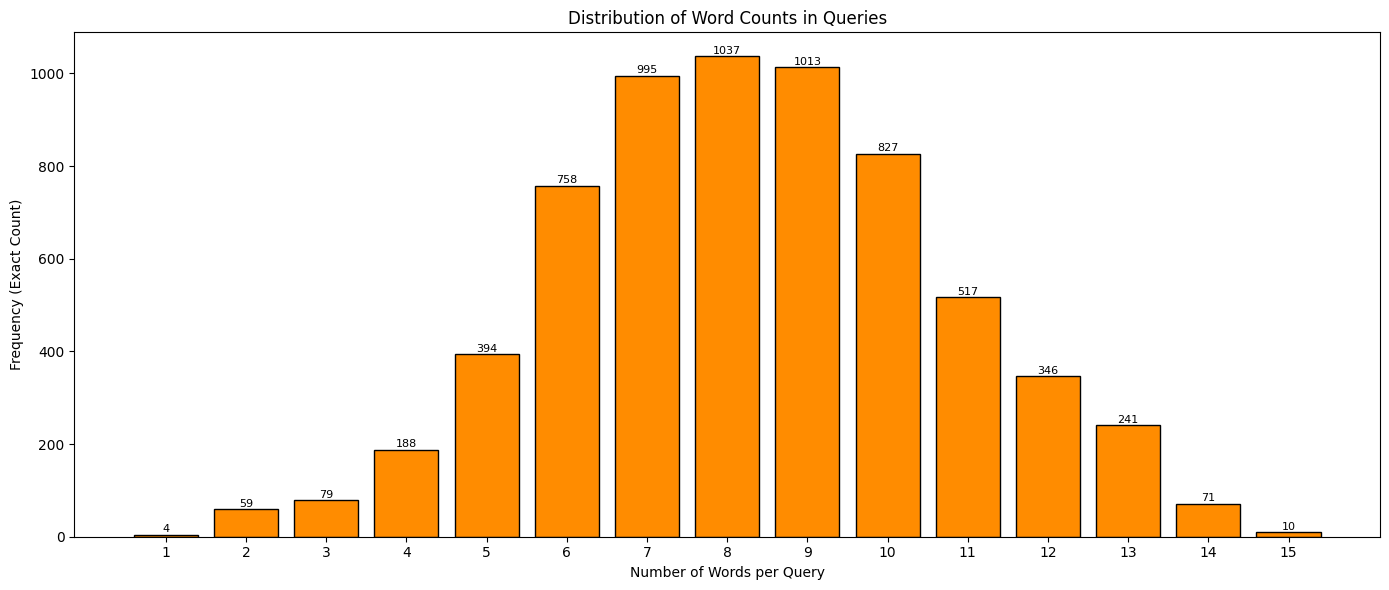

In [33]:
# -------- 4. word Length Stats --------

def analyze_word_counts(queries):
    # Count words per query
    word_counts = queries.apply(lambda x: len(x.split()))
    word_count_freq = Counter(word_counts)
    counts_sorted = sorted(word_count_freq.items())  # (word_count, frequency)

    x = [item[0] for item in counts_sorted]
    y = [item[1] for item in counts_sorted]

    # Print summary stats
    print(f"Min words per query: {min(x)}")
    print(f"Max words per query: {max(x)}")
    print(f"Average words per query: {sum([a * b for a, b in zip(x, y)]) / sum(y):.2f}")

    # Plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(x, y, color='darkorange', edgecolor='black')

    # Add frequency labels on each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=8)

    plt.xticks(x)
    plt.xlabel("Number of Words per Query")
    plt.ylabel("Frequency (Exact Count)")
    plt.title("Distribution of Word Counts in Queries")
    plt.tight_layout()
    plt.show()

analyze_word_counts(queries)


In [26]:
# -------- 4. N-gram Frequency (Unigram/Bigrams) --------
def extract_word_stats(queries, n=1, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vec.fit_transform(queries)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    sorted_freqs = sorted(freqs, key=lambda x: x[1], reverse=True)

    print(f"\nTop {top_k} {n}-grams:")
    for term, freq in sorted_freqs[:top_k]:
        print(f"{term}: {freq}")



extract_word_stats(queries, n=1)



Top 20 1-grams:
help: 1676
check: 1013
need: 871
know: 834
assistance: 719
account: 714
order: 662
want: 658
address: 474
delivery: 421
payment: 411
shipping: 410
refund: 409
don: 356
information: 315
options: 293
customer: 291
invoices: 269
user: 264
invoice: 257


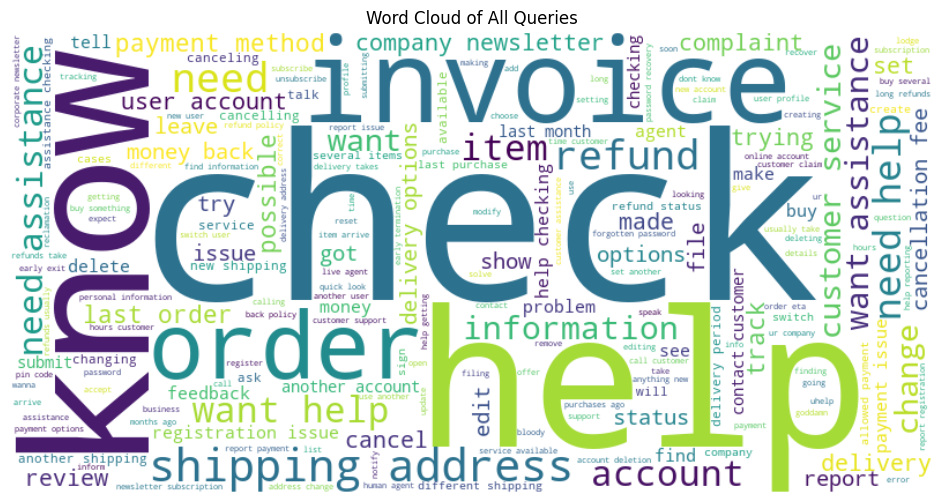

In [27]:
# -------- 5. Word Cloud --------
def show_wordcloud(queries):
    all_text = ' '.join(queries.tolist())
    cloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of All Queries")
    plt.show()


show_wordcloud(queries)


In [44]:
# -------- 6. Word cloud for misspellings --------

import pandas as pd
import nltk
import re
from nltk.corpus import words as nltk_words, wordnet
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (run once)
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Load English vocabulary set:
english_vocab = set(w.lower() for w in nltk_words.words())

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Map NLTK POS tags to WordNet POS tags:
def get_wordnet_pos(word):
    """Return WordNet POS tag from NLTK POS notation for better lemmatization."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def tokenize(text):
    """Simple tokenizer to extract words in lowercase."""
    return re.findall(r'\b[a-z]+\b', text.lower())

def detect_misspellings(df, query_col='Queries', exclude_top_n=0):
    misspelling_counts = {}

    for query in df[query_col].dropna().astype(str):
        tokens = tokenize(query)
        for word in tokens:
            if len(word) <= 2:
                continue  # skip very short words like "I", "to", "at"
            if word in english_vocab:
                continue  # correct spelling
            # Lemmatize word with POS tag
            lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            if lemma in english_vocab:
                continue  # lemma recognized, so word considered correct
            # Mark as misspelled
            misspelling_counts[word] = misspelling_counts.get(word, 0) + 1

    # Sort misspellings by frequency descending:
    sorted_misspellings = sorted(misspelling_counts.items(), key=lambda x: x[1], reverse=True)

    # Print top 10 most frequent misspellings overall:
    print(f"Top 10 misspellings overall:")
    for word, count in sorted_misspellings[:10]:
        print(f"{word}: {count} occurrences")

    # Exclude top n frequent misspellings if desired:
    if exclude_top_n > 0:
        filtered_misspellings = sorted_misspellings[exclude_top_n:]
    else:
        filtered_misspellings = sorted_misspellings

    print(f"\nMisspellings list after excluding top {exclude_top_n} most frequent:")
    for word, count in filtered_misspellings:
        print(f"{word}: {count}")

    # Return lists for programmatic use if needed
    return sorted_misspellings, filtered_misspellings

# Usage example:

# Load your Excel file - adjust path as needed
df = pd.read_excel('SkyRocket Data.xlsx')

# Call the function, e.g., exclude top 5 frequent misspellings:
overall_misspellings, filtered_misspellings = detect_misspellings(df, exclude_top_n=5)

# output the final filtered_misspellings list in a dataframe to a csv file
filtered_df = pd.DataFrame(filtered_misspellings, columns=['Misspelling', 'Count'])
filtered_df.to_csv('filtered_misspellings.csv', index=False)


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Top 10 misspellings overall:
online: 75 occurrences
reporting: 54 occurrences
signup: 42 occurrences
unsubscribe: 30 occurrences
buying: 27 occurrences
wanna: 26 occurrences
info: 23 occurrences
goddamn: 22 occurrences
uhelp: 22 occurrences
fucking: 18 occurrences

Misspellings list after excluding top 5 most frequent:
wanna: 26
info: 23
goddamn: 22
uhelp: 22
fucking: 18
cancelations: 9
pwd: 9
signing: 6
mom: 6
freemium: 5
refundable: 4
uare: 4
acount: 3
isn: 3
avaqilable: 2
google: 2
ehlp: 2
needhelp: 2
cannott: 2
tto: 2
hwat: 2
cutomer: 2
asistance: 2
wiht: 2
acn: 1
newsleter: 1
organizxation: 1
changew: 1
uswer: 1
icreate: 1
checkimg: 1
utell: 1
paymnent: 1
lcaim: 1
canyou: 1
ccan: 1
penaltie: 1
chnage: 1
creaitng: 1
differentuser: 1
newslewtter: 1
infornation: 1
diffreent: 1
chattinb: 1
whattime: 1
checkingf: 1
filign: 1
clpaim: 1
avcount: 1
areavailable: 1
acocunt: 1
informatoin: 1
helpretrieving: 1
hepp: 1
hewlp: 1
termniation: 1
abuot: 1
ohurs: 1
accont: 1
mke: 1
onlikne: 1
hyma

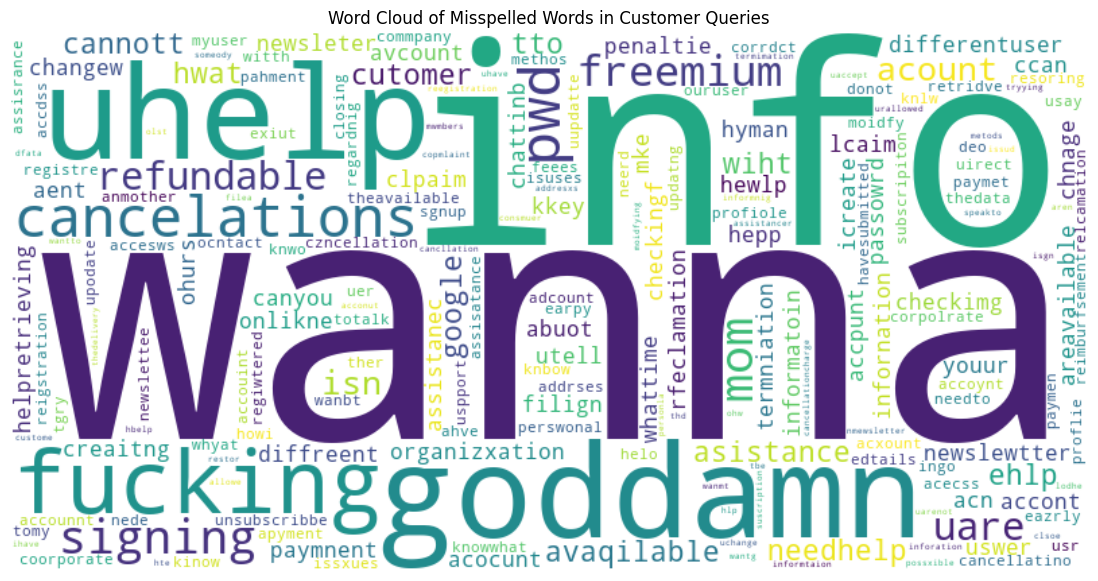

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Prepare a dictionary of misspellings and their frequencies
word_freq = dict(filtered_misspellings)  # from your existing misspellings list

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Misspelled Words in Customer Queries')
plt.show()


In [35]:
# -------- 7. Template Phrase Extractor --------
def find_common_templates(queries, top_k=15):
    templates = []
    patterns = [
        r'how do i \w+',
        r'i want to \w+',
        r'can you \w+',
        r'please \w+',
        r'i need \w+',
        r'what is \w+'
    ]
    for query in queries:
        for p in patterns:
            match = re.search(p, query)
            if match:
                templates.append(match.group())

    template_series = pd.Series(templates)
    top_templates = template_series.value_counts().head(top_k)
    print("\nTop repeated templates:")
    print(top_templates)


find_common_templates(queries)



Top repeated templates:
can you help          285
i need to             280
i need help           264
i need assistance     216
i want to check        33
can you tell           31
can you show           28
how do i check         27
i want to know         22
i want to get          12
i need information     12
how do i get           10
can you give            9
i want to report        8
what is the             7
Name: count, dtype: int64
